In [2]:
import sys
sys.path.append('/Users/aimeebarciauskas/Library/Python/3.6/lib/python/site-packages')
sys.path.append('/Users/aimeebarciauskas/Library/Python/3.7/lib/python/site-packages')
sys.path.append('/Users/aimeebarciauskas/Projects/ifsc/')
import psycopg2
import pycountry
import helpers

/Users/aimeebarciauskas/Library/Python/3.6/lib/python/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
query = """
select count(*), athletes.nation as nation, comps.year as year from bouldering_comp_results
  join athletes on athletes.id = bouldering_comp_results.athlete_id
  join comps on bouldering_comp_results.comp_id = comps.id
where bouldering_comp_results.comp_stage = 'semifinal'
group by nation, year
order by nation, year;
"""

countries_semifinals_counts = helpers.raw_fetch(query)
countries_semifinals_counts[0:10]

[(6, 'AUS', 2007),
 (1, 'AUS', 2009),
 (2, 'AUS', 2010),
 (3, 'AUS', 2011),
 (3, 'AUS', 2012),
 (4, 'AUS', 2013),
 (9, 'AUS', 2014),
 (3, 'AUS', 2015),
 (1, 'AUS', 2016),
 (27, 'AUT', 2007)]

In [5]:
query = """
select distinct(athletes.nation) from bouldering_comp_results
  join athletes on athletes.id = bouldering_comp_results.athlete_id
where bouldering_comp_results.comp_stage = 'semifinal';
"""

nations = helpers.format_rows(helpers.raw_fetch(query))
nations[0:10]

['NED', 'VEN', 'USA', 'SRB', 'HUN', 'SUI', 'AUT', 'IRL', 'RUS', 'ISR']

In [6]:
# fill in missing years with 0
year_range = range(2007, 2018)
# Verified with https://en.wikipedia.org/wiki/List_of_IOC_country_codes
alternate_keys = {
    'GER': 'Germany', #DEU
    'BUL': 'Bulgaria', #BGR
    'IRI': 'Iran', #IRN
    'LAT': 'Latvia', #LVA
    'MAS': 'Malaysia', #MYS
    'NED': 'Netherlands', #NLD
    'SLO': 'Slovenia', #SVN
    'SUI': 'Switzerland', #CHE?
    'TPE': 'Taipei' # Not listed'
}

def country_year_map(triplet):
    alpha_3 = triplet[1]
    country = alpha_3
    try:
        country = pycountry.countries.get(alpha_3=alpha_3).name
    except KeyError as e:
        #print('Country for 3-letter not found: {0}'.format(alpha_3))
        country = alternate_keys[alpha_3]

    return {
        'count': triplet[0],
        'alpha_3': alpha_3,
        'country': country,
        'year': triplet[2]
    }

def format_key(alpha_3, year):
    return '{0}_{1}'.format(alpha_3, year)

country_count_maps = list(map(country_year_map, countries_semifinals_counts))
country_count_map_of_maps = {format_key(i['alpha_3'], i['year']): i for i in country_count_maps}

for year in year_range:
    for alpha_3 in nations:
        cy_key = format_key(alpha_3, year)
        if cy_key not in country_count_map_of_maps:
            country_count_map_of_maps[cy_key] = country_year_map([0, alpha_3, year])

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import itertools

In [8]:
import pandas as pd

df = pd.DataFrame(country_count_map_of_maps).T
df.head()

/Users/aimeebarciauskas/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,alpha_3,count,country,year
AUS_2007,AUS,6,Australia,2007
AUS_2009,AUS,1,Australia,2009
AUS_2010,AUS,2,Australia,2010
AUS_2011,AUS,3,Australia,2011
AUS_2012,AUS,3,Australia,2012


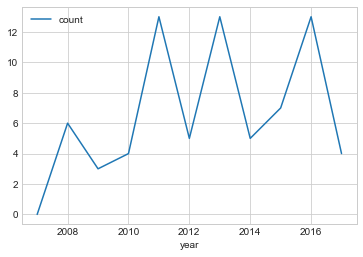

In [9]:
grouped = df.groupby('alpha_3')
usa = grouped.get_group('CAN').sort_values('year')
usa.plot.line(x='year', y='count')

In [84]:
grouped = df.groupby('alpha_3')
jpn = grouped.get_group('JPN').sort_values('year')
jpn

,alpha_3,count,country,year
JPN_2007,JPN,12,Japan,2007
JPN_2008,JPN,17,Japan,2008
JPN_2009,JPN,18,Japan,2009
JPN_2010,JPN,18,Japan,2010
JPN_2011,JPN,23,Japan,2011
JPN_2012,JPN,27,Japan,2012
JPN_2013,JPN,41,Japan,2013
JPN_2014,JPN,39,Japan,2014
JPN_2015,JPN,38,Japan,2015
JPN_2016,JPN,46,Japan,2016


In [86]:
grouped = df.groupby('alpha_3')
jpn = grouped.get_group('FRA').sort_values('year')
jpn

,alpha_3,count,country,year
FRA_2007,FRA,75,France,2007
FRA_2008,FRA,62,France,2008
FRA_2009,FRA,36,France,2009
FRA_2010,FRA,51,France,2010
FRA_2011,FRA,66,France,2011
FRA_2012,FRA,40,France,2012
FRA_2013,FRA,37,France,2013
FRA_2014,FRA,42,France,2014
FRA_2015,FRA,26,France,2015
FRA_2016,FRA,29,France,2016


In [50]:
country_totals = df.groupby('alpha_3').agg({'count': np.sum}).sort_values('count', ascending=False)
total_semi_finalists = country_totals.agg({'count': np.sum})
top_ten = country_totals[0:10]
total_top_ten = top_ten.agg({'count': np.sum})
print('Total semifinalists: {0}, total from top ten countries: {1}'.format(int(total_semi_finalists), int(total_top_ten)))
print('Percentage from top ten countries: {0}'.format(total_top_ten/total_semi_finalists))
top_ten_countries = list(top_ten.index)

Total semifinalists: 2902, total from top ten countries: 2309
Percentage from top ten countries: count    0.795658
dtype: float64


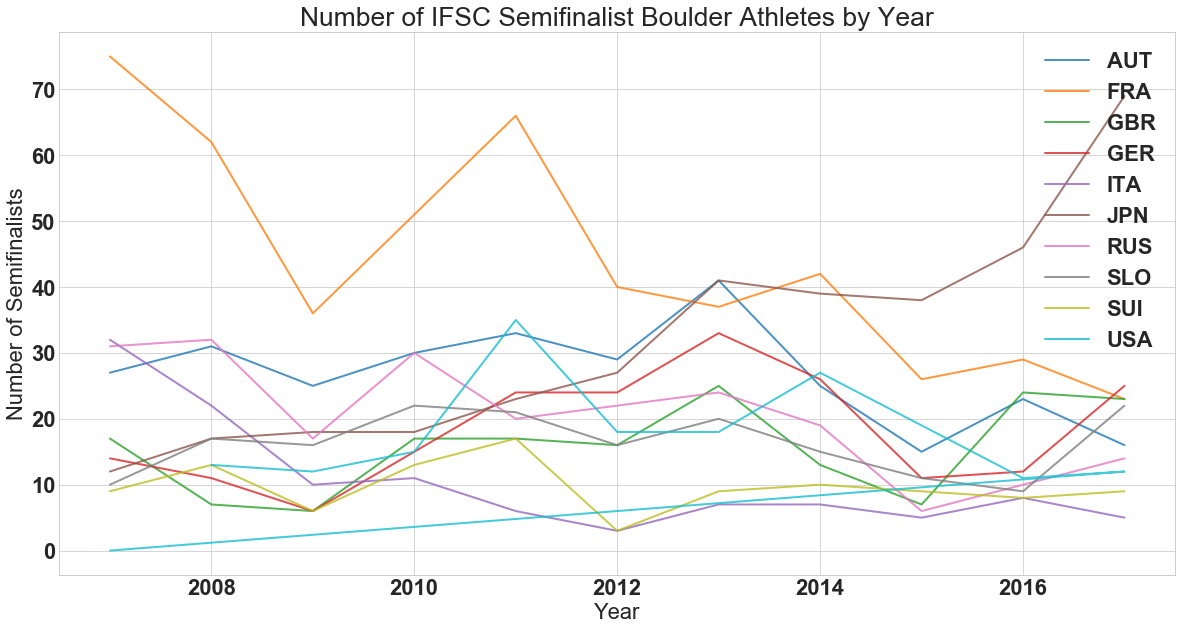

In [83]:
import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'Arial',
        'size'   : 22}

matplotlib.rc('font', **font)
matplotlib.rc('figure', figsize=(20, 10))
fig, ax = plt.subplots()

for key, grp in df.groupby('alpha_3'):
    if key in top_ten_countries:
        ax = grp.plot(ax=ax, kind='line', linewidth='2', alpha=0.8, x='year', y='count', label=key)

plt.title('Number of IFSC Semifinalist Boulder Athletes by Year')
plt.xlabel('Year')
plt.ylabel('Number of Semifinalists')
plt.legend(loc='best')
plt.savefig('semifinal-athletes-by-year.png')
plt.show()